📌 Justificación como modelo analítico
Para que tu enfoque se considere un modelo analítico dentro del TFG, es clave explicar qué hace y por qué lo usaste. Puedes estructurarlo así:

1️⃣ Clasificación por Palabras Clave (Reglas Heurísticas)
¿Qué hace? Busca coincidencias con palabras predefinidas para clasificar los mensajes de manera rápida y eficiente.
¿Por qué usarlo? Es un enfoque sencillo que permite detectar categorías comunes sin necesidad de modelos complejos.
¿Limitaciones? No capta sinónimos ni variaciones del lenguaje, lo que puede generar errores.
2️⃣ Clasificación Zero-Shot con BART (facebook/bart-large-mnli)
¿Qué hace? Predice la categoría de un mensaje sin necesidad de reentrenar el modelo, evaluando cuál de las categorías predefinidas es más probable.
¿Por qué usarlo? Es ideal cuando no se tiene un dataset etiquetado para entrenar un modelo de clasificación desde cero.
¿Limitaciones? Es más lento y puede cometer errores si las categorías están mal definidas o si los mensajes son ambiguos.

In [4]:
# Importar librerías
import pandas as pd
import torch
from transformers import pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# Verificar si hay GPU disponible
device = 0 if torch.cuda.is_available() else -1
print(f"Usando {'GPU' if device == 0 else 'CPU'} para inferencia.")

# Cargar dataset
data = pd.read_csv(r"C:\Users\migui\OneDrive - UFV\4ºBA\TFG\ing dato\only_english_dota2_chats.csv")

# Mostrar las primeras filas del dataset
data.head()

Usando GPU para inferencia.


,match,time,slot,text,cleaned_text,text_en,is_english
0,954334,-26.06113,7,fist item,fist item,Fist item,True
1,756982,85.44562,9,new meta/),new meta,new meta,True
2,925441,2173.20525,5,найс у нас керри гг,найс у нас керри гг,we've got kerry gg.,True
3,946663,1507.19866,6,блять очкошная,блять очкошная,"Fuck, it's a point.",True
4,244781,1298.58290,0,Dont be so nervous lion,Dont be so nervous lion,Dont be so nervous lion,True


In [6]:
# Definir categorías y palabras clave
categories = {
    "chitchat": {"lol", "lmao", "rofl", "xd", "haha", "hahaha", "ez", "gl hf", "gg", "gg wp", "wp gg", "ok", "okay", "fine", "nice", "awesome", "bro", "mate", "dude", "man", "brother", "sister", "fam", "what’s up", "yo", "alright", "cheers", "peace", "relax", "calm down", "take it easy", "sleeping", "monka", "well", "yo wk", "so whose support", "afraid", "husk", "next time", "gj", "gj team", "easy game", "yeah", "good idea", "alche with treads", "maybe next time", "new year", "happy new year", "congrats"},
    "coordination": {"push", "defend", "mid", "bot", "top", "gank", "ward", "bkb", "blink", "tp", "teleport", "rune", "farm", "split push", "group up", "retreat", "back", "go", "come", "rotate", "cooldown", "mana", "hp", "regen", "buyback", "lane", "position", "carry", "support", "offlane", "midlaner", "jungler", "objective", "strategy", "skadi", "heart", "item", "buy", "veil", "aether", "build", "switch", "treads", "team doesn’t want to stick", "stick together", "wait for", "tp mid", "gg void farm", "group on mid", "rush roshan", "vision", "take rosh", "initiate", "help", "stack", "take tower"},
    "toxic_offense": {"idiot", "moron", "stupid", "trash", "garbage", "dumb", "useless", "clown", "loser", "wtf", "fucking", "fk", "noob", "feed", "feeder", "stop feeding", "afk", "troll", "throw", "tilt", "inting", "int", "worthless", "skill issue", "report", "mute", "kick", "ban", "worst", "pathetic", "dumbass", "get good", "git gud", "bad player", "annoying", "so bad", "uninstall", "should quit", "delete game", "kys", "idiot sf", "worst", "why so ez", "report jug", "go end", "who is better", "no wait", "gj team", "bad player", "bitchin", "mid noob", "trash"},
    "gender_discrimination": {"girl", "woman", "female", "whore", "slut", "bitch", "hoe", "thot", "simp", "feminazi", "make me a sandwich", "go back to the kitchen", "girly", "cry like a girl", "weak like a woman", "she can't play", "girl gamer", "men are better", "woman moment", "beta male", "soyboy", "white knight", "man up", "real men", "alpha male", "women shouldn't play", "girls are bad at games", "stay in the kitchen", "feminist garbage", "she is bad", "weak girl", "real gamers are men"},
    "religious_intolerance": {"allah", "islam", "muslim", "christian", "jew", "atheist", "buddhist", "hindu", "infidel", "heretic", "burn in hell", "holy war", "crusade", "jihad", "terrorist", "extremist", "false god", "god is dead", "praise allah", "hail satan", "convert or die", "religion is stupid", "god doesn’t exist", "anti-christ", "you will burn", "bible basher", "go pray", "false prophet", "your religion is trash", "believers are dumb", "god doesn’t care", "faith is for the weak", "pray harder", "holy shit", "burn the church", "godless fool", "you deserve hell"},
    "racism": {"nigger", "negro", "coon", "monkey", "ape", "subhuman", "slave", "cotton picker", "kfc", "watermelon", "chink", "gook", "zipperhead", "ching chong", "wetback", "beaner", "spic", "gringo", "cracker", "redneck", "white trash", "karen", "snowflake", "race war", "white power", "heil hitler", "kkk", "nazi", "fascist", "immigrant", "go back to your country", "border hopper", "mudblood", "mongrel", "half-breed", "asian dog", "latino trash", "european scum", "dark-skinned trash", "racist pig", "go back to Africa", "euro mutt", "chinese virus", "mexican invader", "illegal alien", "spic bastard"}
}



# Convertir las categorías a una lista para Zero-Shot
candidate_labels = list(categories.keys())

# Mostrar las categorías definidas
print("Categorías definidas:", candidate_labels)

Categorías definidas: ['chitchat', 'coordination', 'toxic_offense', 'gender_discrimination', 'religious_intolerance', 'racism']


In [7]:
# Función para limpiar el texto
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Elimina caracteres especiales
    text = text.lower()  # Convierte a minúsculas
    return text

# Aplicar limpieza a la columna de texto
data['text_en'] = data['text_en'].astype(str).apply(clean_text)

# Mostrar un ejemplo de texto limpio
print("Ejemplo de texto limpio:", data['text_en'].iloc[0])

Ejemplo de texto limpio: fist item


In [8]:
# Función para clasificación rápida basada en palabras clave
def keyword_classification(text):
    text_lower = text.lower()
    for category, words in categories.items():
        if any(word in text_lower for word in words):
            return category
    return None  # Si no hay coincidencia, usar Zero-Shot

# Aplicar clasificación rápida
data['predicted_label'] = data['text_en'].apply(keyword_classification)

# Mostrar la distribución de las categorías asignadas
print("Distribución de categorías después de la clasificación rápida:")
print(data['predicted_label'].value_counts())

Distribución de categorías después de la clasificación rápida:
predicted_label
chitchat                 20680
coordination              8161
toxic_offense             6472
gender_discrimination      620
racism                     128
religious_intolerance       42
Name: count, dtype: int64


In [9]:
# Filtrar mensajes que no tienen etiqueta
unclassified_texts = data[data['predicted_label'].isna()]['text_en'].tolist()

# Mostrar cuántos mensajes quedan sin clasificar
print(f"Mensajes sin clasificar: {len(unclassified_texts)}")

Mensajes sin clasificar: 37474


In [10]:
# Cargar modelo Zero-Shot en GPU si está disponible
model = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

# Procesar en lotes para optimizar memoria y rendimiento
batch_size = 512  # Ajusta según tu VRAM disponible
num_batches = (len(unclassified_texts) // batch_size) + 1

predicted_labels = []
tqdm_bar = tqdm(total=len(unclassified_texts), desc="Clasificando con Zero-Shot")

with torch.no_grad():  # Desactivar gradientes para mayor eficiencia
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(unclassified_texts))
        batch_texts = unclassified_texts[start:end]

        if not batch_texts:
            continue
        
        try:
            results = model(batch_texts, candidate_labels=candidate_labels)
            for result in results:
                predicted_labels.append(result['labels'][np.argmax(result['scores'])])
        except Exception as e:
            print(f"Error en el lote {i}: {e}")
            predicted_labels.extend([None] * len(batch_texts))  # Asignar None en caso de error

        tqdm_bar.update(len(batch_texts))  # Actualizar barra de progreso

tqdm_bar.close()

# Mostrar un ejemplo de las etiquetas predichas
print("Ejemplo de etiquetas predichas:", predicted_labels[:10])

Clasificando con Zero-Shot: 100%|██████████| 37474/37474 [1:31:19<00:00,  6.84it/s]

Ejemplo de etiquetas predichas: ['coordination', 'coordination', 'coordination', 'coordination', 'toxic_offense', 'coordination', 'chitchat', 'coordination', 'chitchat', 'coordination']


In [11]:
# Asignar etiquetas Zero-Shot al dataset

data.loc[data['predicted_label'].isna(), 'predicted_label'] = predicted_labels

# Mostrar la distribución final de las categorías
print("Distribución final de categorías:")
print(data['predicted_label'].value_counts())

Distribución final de categorías:
predicted_label
chitchat                 29866
coordination             25082
toxic_offense            16627
gender_discrimination      895
racism                     776
religious_intolerance      331
Name: count, dtype: int64


In [12]:
# Guardar dataset etiquetado en un archivo CSV
data.to_csv('classified_dota2_chats.csv', index=False)

# Confirmar que el archivo se ha guardado
print("Dataset etiquetado guardado como 'classified_dota2_chats.csv'.")

Dataset etiquetado guardado como 'classified_dota2_chats.csv'.


In [17]:
data.sample(5)

,match,time,slot,text,cleaned_text,text_en,is_english,predicted_label
37067,702342,1537.12466,9,accdg to dotabuff,accdg to dotabuff,accdg to dotabuff,True,coordination
9195,426739,2055.27092,8,3к урона...,к урона,to the loss,True,toxic_offense
18563,86209,993.52410,2,русский сервер,русский сервер,russian server,True,coordination
19021,633929,1464.27582,7,у нас тоже лесник,у нас тоже лесник,we have a forester too,True,coordination
67611,728164,2211.35190,0,he just crying,he just crying,he just crying,True,toxic_offense


C:\Users\migui\AppData\Local\Temp\ipykernel_2628\2174019829.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data['predicted_label'], order=data['predicted_label'].value_counts().index, palette="viridis")


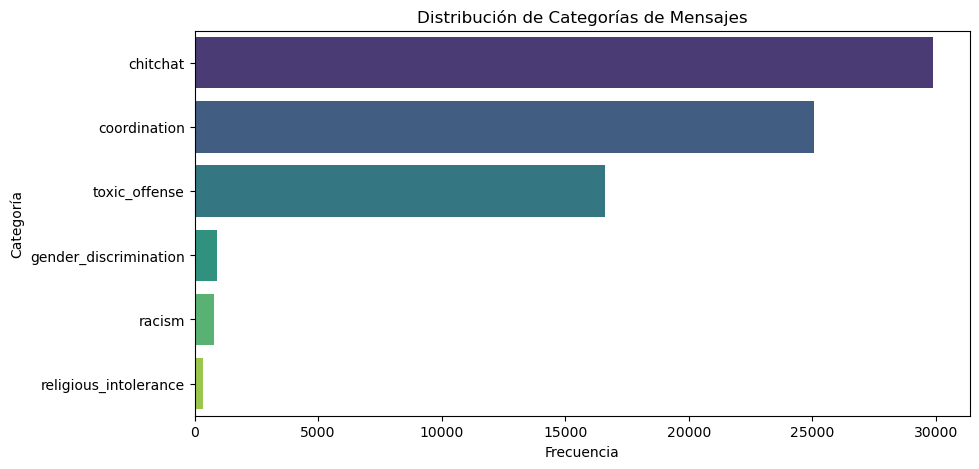

In [18]:
# Visualización: Distribución de categorías
plt.figure(figsize=(10, 5))
sns.countplot(y=data['predicted_label'], order=data['predicted_label'].value_counts().index, palette="viridis")
plt.title("Distribución de Categorías de Mensajes")
plt.xlabel("Frecuencia")
plt.ylabel("Categoría")
plt.show()

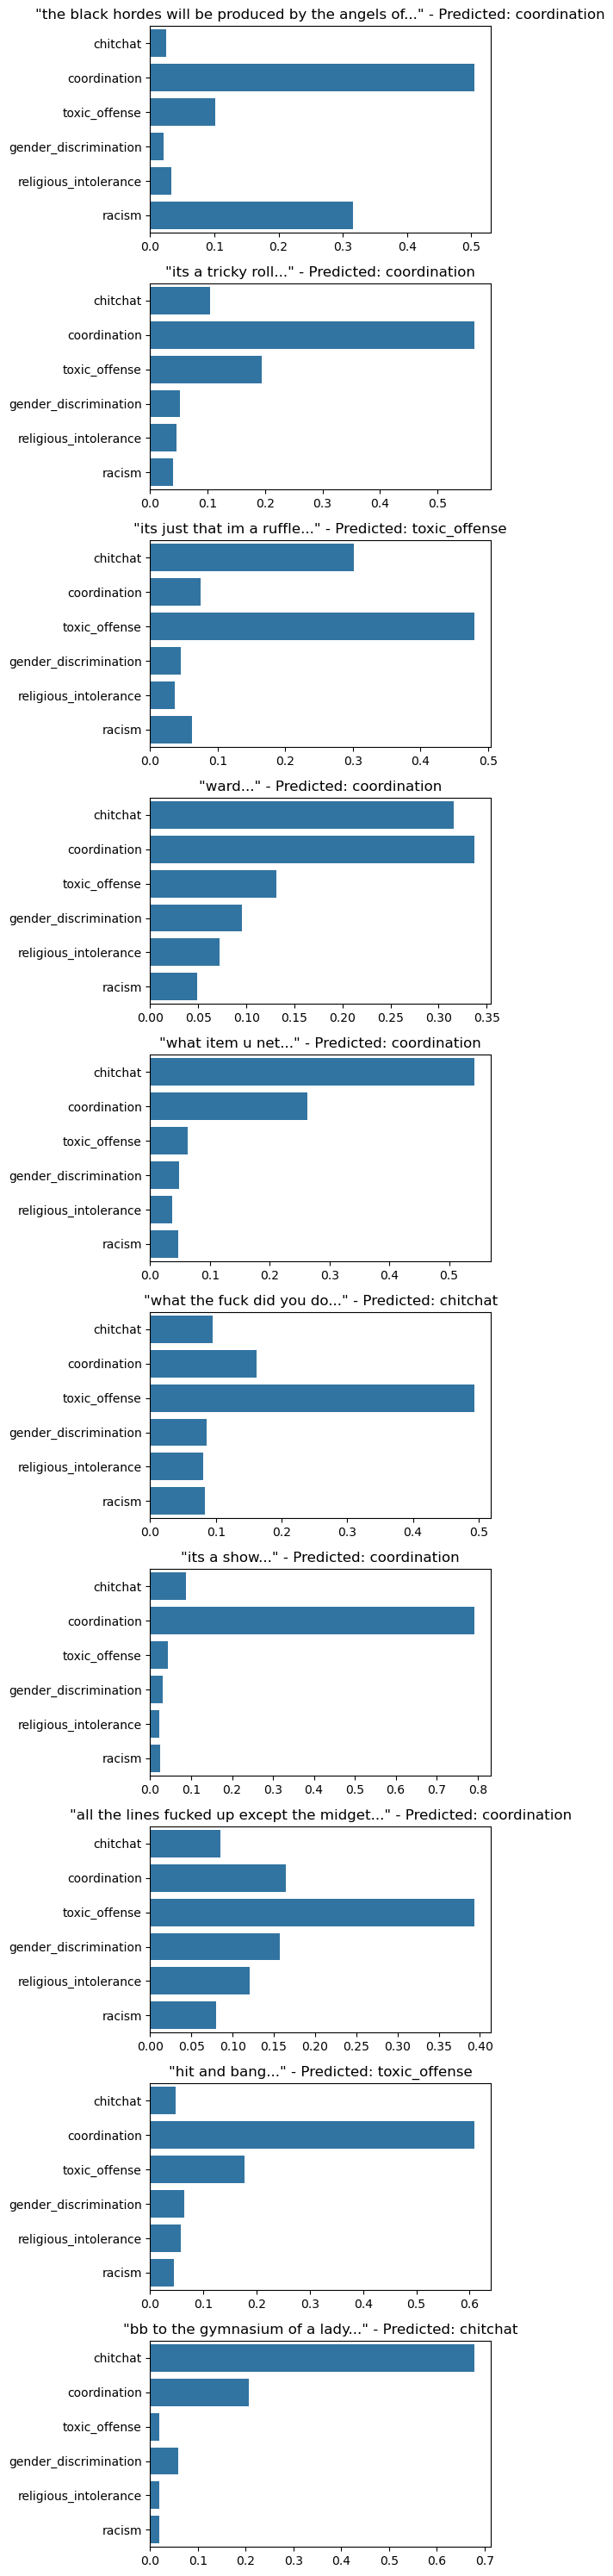

In [19]:
# Visualización detallada de predicciones aleatorias
how_many_to_plot = 10
sample_data = data.sample(how_many_to_plot)

fig, ax = plt.subplots(nrows=how_many_to_plot, figsize=(6, 30))

for i, row in enumerate(sample_data.itertuples()):
    text = row.text_en
    label = row.predicted_label
    prob_scores = model(text, candidate_labels=candidate_labels)  # Obtener probabilidades

    sns.barplot(y=prob_scores["labels"], x=prob_scores["scores"], ax=ax[i], order=candidate_labels)
    ax[i].set_title(f'"{text[:50]}..." - Predicted: {label}')

fig.tight_layout()
plt.show()

In [ ]:
# 📌 Seleccionar solo las columnas esenciales
data = data[['match', 'time', 'slot', 'text_en', 'predicted_label']]

# 📌 Eliminar filas con valores nulos (si las hay)
data = data.dropna()

# 📌 Guardar el dataset limpio con el nuevo nombre
data.to_csv('cleaned_clasified_Dota2_chats.csv', index=False)

print("✅ Dataset limpio guardado como 'cleaned_clasified_Dota2_chats.csv'.")